In [64]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import numpy as np
import transformers
import os
import re
import torch
import torch.nn as nn
import sys
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A) PREPROCESSING 

##  1) Custom Dataset Class
#### Implement a map-style dataset from .csv files; needed because data files train_titles.csv and test_titles.csv cannot be directly passed to the dataloader

In [65]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset

class customTextDataset(Dataset):
    def __init__(self, path, colnames, maxLen, tokenizer=None): 
        self.data =  pd.read_csv(path, names=colnames, header=None, sep = ',', index_col=False)
        self.tokenizer = tokenizer
        self.maxLen = maxLen

    def __getitem__(self, idx):
        sentence = self.data.loc[idx].text
        out = self.tokenizer(sentence, padding = 'max_length', truncation = True, max_length = self.maxLen)
        ids = out['input_ids']
        mask = torch.tensor(out['attention_mask'])
        ids = torch.tensor(ids)
        # label
        label = self.data.loc[idx].food
        return ids, mask, label
        #return torch.tensor(ids),label # torch.tensor(sentence), mask, label

    def __len__(self):
        return len(self.data)

    def getHead(self):
        print(self.data.head())



## 2) DistilBert Tokenizer from Huggingface

In [66]:
from torch.utils.data import DataLoader
maxLen = 128
batchSize = 512
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
vocabSize = len(tokenizer)
print(f"Vocabulary Size = {vocabSize}")

Vocabulary Size = 30522


## 3) Create Custom Dataloaders from  Text Dataset

In [67]:
trainData = customTextDataset(path = 'train_titles.csv', colnames=['image_path', 'text', 'food'], tokenizer = tokenizer,maxLen=maxLen)
trainLoader = DataLoader(trainData,batch_size=batchSize,shuffle=True)
print(f'Number of train data points  = {trainData.__len__()}')
#trainData.getHead()
testData = customTextDataset(path = 'test_titles.csv', colnames=['image_path', 'text', 'food'], tokenizer = tokenizer,maxLen=maxLen)
testLoader = DataLoader(testData, batch_size=1, shuffle=True)
print(f"Number of test data points = {testData.__len__()}")

Number of train data points  = 67972
Number of test data points = 22716


#### Print an example data point: tokens/tokenIds and the corresponding label

In [68]:
data = next(iter(trainLoader))
print(f"Encoded Text = {data[0][0]}, {data[0][0].type()}, {data[0][0].shape}")
print(f"Mask = {data[1][0]}, {data[1][0].type()}, {data[1][0].shape}")
print(f"Encoded Label = {data[2][0]}")
print(f"Decoded tokens from encoded ids: \n'{tokenizer.decode(data[0][0])}'")

Encoded Text = tensor([  101,  3313,  6207, 11345,  2007,  9781,  4168,  2389, 19116, 17974,
         1064,  2026,  2890,  6895, 10374,  1012,  4012,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,

## 4) Convert categorical labels (recipe names) to numerical labels ({0,1,2,....101})

In [69]:
labelsTrain_ = []
for data in trainLoader:
    labelsTrain_ = labelsTrain_ + (list(data[2]))
  
from collections import Counter
labelsDict = Counter(labelsTrain_)
keys = labelsDict.keys()
lblMap = {x:i for i,x in enumerate(keys)}
print(f"Number of classes = {len(list(keys))}") # This should be 101 

Number of classes = 101


# B) DISTILBERT + FEEDFORWARD MODEL

In [70]:
import numpy
import torch.optim as optim

numClasses = 101
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels = numClasses)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
lossVals = []
print(model)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## 1) Fine-tune Distilbert model on the Food-101 dataset

In [71]:
numEpochs = 3
for epoch in range(numEpochs):  # loop over the dataset multiple times
    for data in trainLoader:
        ids,masks,labels_ = data # masks is of dimension (batchsize,  maxLen, maxLen)
        labels = torch.tensor([lblMap[x] for x in labels_]) 
        optimizer.zero_grad()
        ids = ids.to(device)
        masks = masks.to(device)
        labels = labels.to(device)
        outputs = model(input_ids = ids, attention_mask = masks,labels = labels)
        loss = outputs[0]
        loss.backward()
        lossVals.append(loss.detach().cpu().clone().numpy())
        optimizer.step()
    if epoch%1 == 0:
        print(f"Epoch = {epoch}. Loss = {loss}")
print('Finished Training')

Epoch = 0. Loss = 0.8261443972587585
Epoch = 1. Loss = 0.6356685161590576
Epoch = 2. Loss = 0.5103889107704163
Finished Training


## 2) Test Distilbert model

In [72]:
model.eval() # again no gradients needed - so set mode.eval()
correct_pred = 0
numTst = 0
for data in testLoader:
    ids,masks,labels_ = data
    numTst = numTst + ids.shape[0]
    labels = torch.tensor([lblMap[x] for x in labels_]) 
    ids = ids.to(device)
    masks = masks.to(device)
    labels = labels.to(device)
    outputs = model(ids, attention_mask = masks, labels = labels)
    _, predictions = torch.max(outputs[1], 1)
    # collect the correct predictions for each class
    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred += 1

accuracy = 100 * float(correct_pred)/ numTst
print(f"Classification Accuracy = {accuracy:.3f}%")

Classification Accuracy = 86.393%


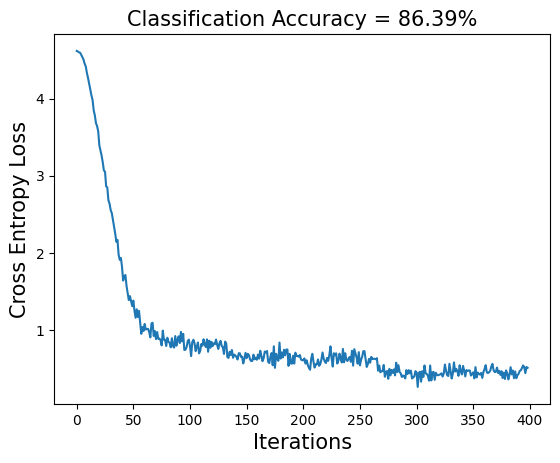

In [ ]:
import numpy as np
fig, ax = plt.subplots(nrows = 1, ncols=1)
ax.plot(range(len(lossVals)),lossVals)
ax.set_xlabel('Iterations',fontsize = 15)
ax.set_ylabel('Cross Entropy Loss', fontsize = 15)
ax.set_title('Classification Accuracy = {:.2f}%'.format(accuracy),fontsize = 15)
#path = 'dim_{}_accry_{:.2f}len_{}_hidden_{}'.format(dModel,accuracy, maxLen,hidden_size)
#plt.savefig(path+'.pdf')